In [1]:

from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import confusion_matrix

from keras.utils import np_utils
from keras.preprocessing import image
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential  


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from glob import glob
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive



In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
file_id = '1dyWEXzKoQs0O8JGnrTQhgE5oESYixAD-' # URL id. 
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('driver.zip')
!unzip driver.zip


Streaming output truncated to the last 5000 lines.
  inflating: imgs/train/c7/img_56661.jpg  
  inflating: imgs/train/c7/img_56699.jpg  
  inflating: imgs/train/c7/img_56717.jpg  
  inflating: imgs/train/c7/img_56724.jpg  
  inflating: imgs/train/c7/img_56768.jpg  
  inflating: imgs/train/c7/img_56779.jpg  
  inflating: imgs/train/c7/img_56849.jpg  
  inflating: imgs/train/c7/img_56899.jpg  
  inflating: imgs/train/c7/img_56938.jpg  
  inflating: imgs/train/c7/img_5706.jpg  
  inflating: imgs/train/c7/img_57076.jpg  
  inflating: imgs/train/c7/img_57122.jpg  
  inflating: imgs/train/c7/img_57137.jpg  
  inflating: imgs/train/c7/img_5715.jpg  
  inflating: imgs/train/c7/img_57278.jpg  
  inflating: imgs/train/c7/img_57321.jpg  
  inflating: imgs/train/c7/img_57345.jpg  
  inflating: imgs/train/c7/img_57355.jpg  
  inflating: imgs/train/c7/img_5741.jpg  
  inflating: imgs/train/c7/img_57433.jpg  
  inflating: imgs/train/c7/img_5753.jpg  
  inflating: imgs/train/c7/img_57559.jpg  
  infla

In [5]:
# define function to load datasets
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), 10)
    return files, targets



In [6]:
# load train, test, and validation datasets
train_files, train_targets = load_dataset('/content/imgs/train')
# load list of names
names = [item[17:19] for item in sorted(glob("/content/imgs/train/*/"))]


In [7]:
# break training set into training and validation sets
train_files, valid_files, train_targets, valid_targets = train_test_split(train_files, train_targets, test_size=0.2, random_state=42)


In [8]:
# print statistics about the dataset
print('There are %s total images.\n' % len(np.hstack([train_files, valid_files])))
print('There are %d training images.' % len(train_files))
print('There are %d total training categories.' % len(names))
print('There are %d validation images.' % len(valid_files))

There are 22424 total images.

There are 17939 training images.
There are 10 total training categories.
There are 4485 validation images.


In [9]:
##Data Exploration
df = pd.read_csv("/content/driver_imgs_list.csv",header='infer')
print(df['classname'].head(3))
print(df.iloc[:,1].describe())
print("\n Image Counts")
print(df['classname'].value_counts(sort=False))

0    c0
1    c0
2    c0
Name: classname, dtype: object
count     22424
unique       10
top          c0
freq       2489
Name: classname, dtype: object

 Image Counts
c9    2129
c2    2317
c3    2346
c7    2002
c0    2489
c1    2267
c6    2325
c4    2326
c5    2312
c8    1911
Name: classname, dtype: int64


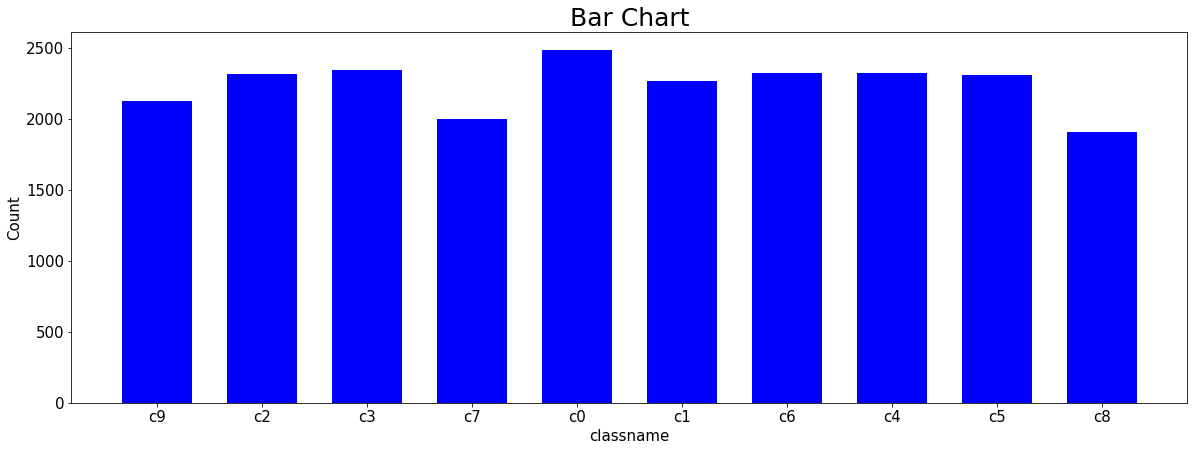

In [10]:
#Visualization
# Pretty display for notebooks
%matplotlib inline

nf = df['classname'].value_counts(sort=False)
labels = df['classname'].value_counts(sort=False).index.tolist()
y = np.array(nf)
width = 1/1.5
N = len(y)
x = range(N)

fig = plt.figure(figsize=(20,15))
ay = fig.add_subplot(211)

plt.xticks(x, labels, size=15)
plt.yticks(size=15)

ay.bar(x, y, width, color="blue")

plt.title('Bar Chart',size=25)
plt.xlabel('classname',size=15)
plt.ylabel('Count',size=15)

plt.show()

In [11]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(64, 64))
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [12]:
# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255 - 0.5

100%|██████████| 17939/17939 [01:15<00:00, 238.65it/s]


In [13]:
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255 - 0.5

100%|██████████| 4485/4485 [00:19<00:00, 235.94it/s]


In [14]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(64,64,3), kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=512, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(500, activation='relu', kernel_initializer='glorot_normal'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       32896     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       131328    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 512)         5

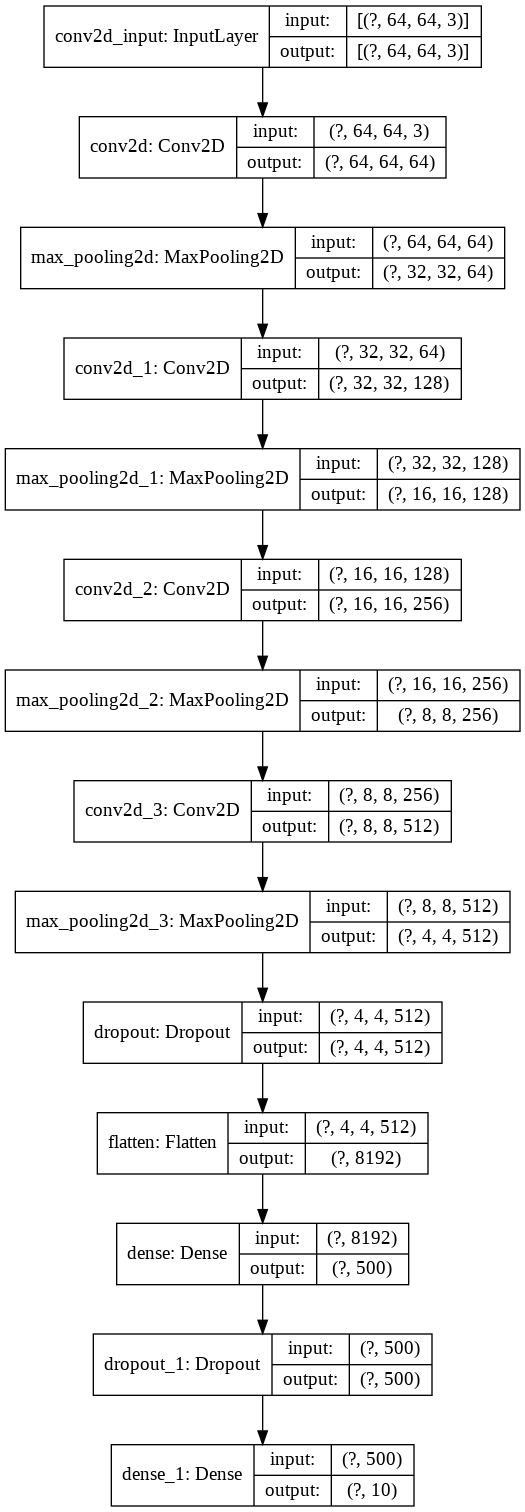

In [15]:
plot_model(model,to_file="model_distracted_driver.png",show_shapes=True,show_layer_names=True)


In [16]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


In [17]:
epochs = 30
checkpointer = ModelCheckpoint(filepath='/content/gdrive/My Drive/weights/cnn_base_weights.best.from_scratch.hdf5', 
                               verbose=1,monitor='val_accuracy', save_best_only=True,mode='max')

fit_output=model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=40,shuffle=True, callbacks=[checkpointer], verbose=1)

Epoch 1/30
449/449 [==============================] - ETA: 0s - loss: 1.0291 - accuracy: 0.6370
Epoch 00001: val_accuracy improved from -inf to 0.92709, saving model to /content/gdrive/My Drive/weights/vgg_base_weights.best.from_scratch.hdf5
449/449 [==============================] - 8s 17ms/step - loss: 1.0291 - accuracy: 0.6370 - val_loss: 0.2331 - val_accuracy: 0.9271
Epoch 2/30
447/449 [============================>.] - ETA: 0s - loss: 0.2132 - accuracy: 0.9321
Epoch 00002: val_accuracy improved from 0.92709 to 0.95920, saving model to /content/gdrive/My Drive/weights/vgg_base_weights.best.from_scratch.hdf5
449/449 [==============================] - 7s 17ms/step - loss: 0.2129 - accuracy: 0.9323 - val_loss: 0.1428 - val_accuracy: 0.9592
Epoch 3/30
447/449 [============================>.] - ETA: 0s - loss: 0.1256 - accuracy: 0.9635
Epoch 00003: val_accuracy improved from 0.95920 to 0.98506, saving model to /content/gdrive/My Drive/weights/vgg_base_weights.best.from_scratch.hdf5
449/

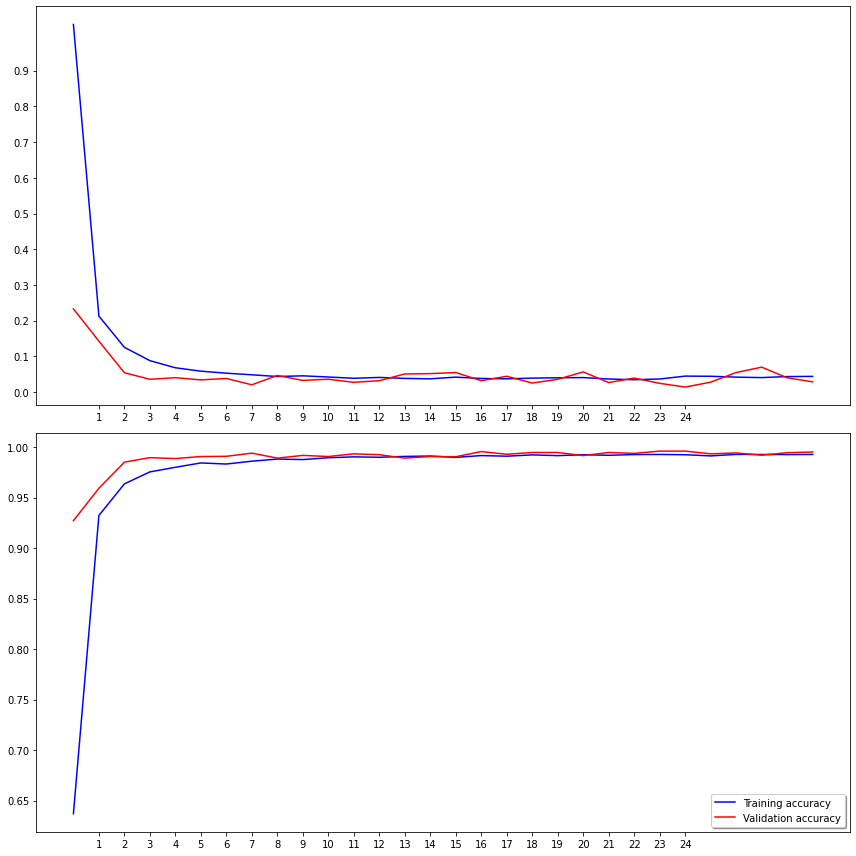

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(fit_output.history['loss'], color='b', label="Training loss")
ax1.plot(fit_output.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 25, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(fit_output.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(fit_output.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 25, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [19]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [20]:
def print_heatmap(n_labels, n_predictions, class_names):
    labels = n_labels #sess.run(tf.argmax(n_labels, 1))
    predictions = n_predictions #sess.run(tf.argmax(n_predictions, 1))

#     confusion_matrix = sess.run(tf.contrib.metrics.confusion_matrix(labels, predictions))
    matrix = confusion_matrix(labels.argmax(axis=1),predictions.argmax(axis=1))
    row_sum = np.sum(matrix, axis = 1)
    w, h = matrix.shape

    c_m = np.zeros((w, h))

    for i in range(h):
        c_m[i] = matrix[i] * 100 / row_sum[i]

    c = c_m.astype(dtype = np.uint8)
    heatmap = print_confusion_matrix(c, class_names, figsize=(18,10), fontsize=20)

In [21]:
class_names = list()
for name,idx in df['classname'].value_counts(sort=False).items():
    class_names.append(name)
ypred = model.predict(valid_tensors)

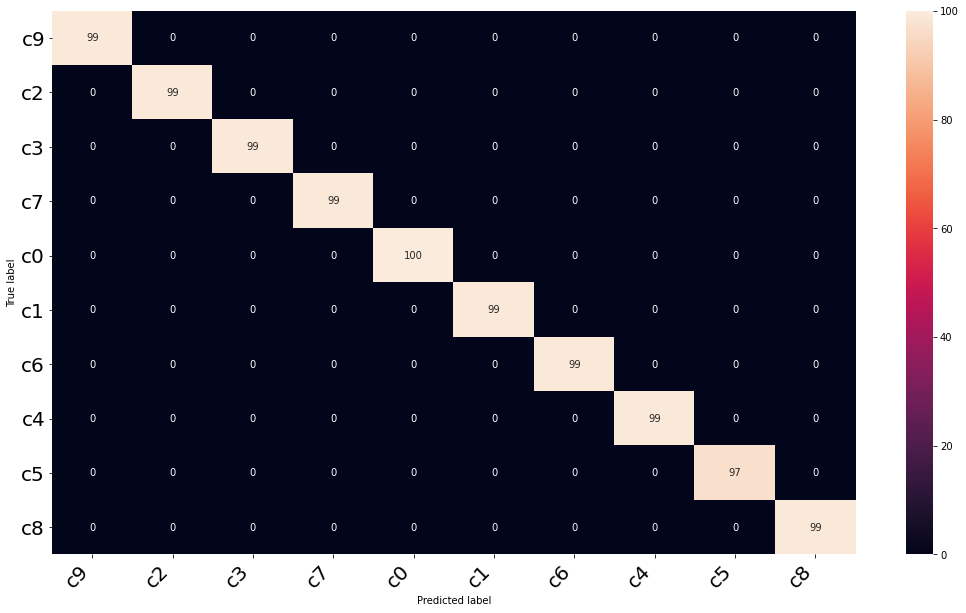

In [22]:
print_heatmap(valid_targets,ypred,class_names)


In [23]:
ypred_class = np.argmax(ypred,axis=1)
ytest = np.argmax(valid_targets,axis=1)

In [24]:
accuracy = accuracy_score(ytest,ypred_class)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(ytest, ypred_class,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(ytest,ypred_class,average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(ytest,ypred_class,average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.995095
Precision: 0.995100
Recall: 0.995095
F1 score: 0.995088


In [25]:
model.load_weights('/content/gdrive/My Drive/weights/cnn_base_weights.best.from_scratch.hdf5')


In [26]:
!unzip mini_test.zip


Archive:  mini_test.zip
   creating: mini_test/
   creating: mini_test/test/
  inflating: mini_test/test/img_347.jpg  
  inflating: mini_test/test/img_348.jpg  
  inflating: mini_test/test/img_349.jpg  
  inflating: mini_test/test/img_350.jpg  
  inflating: mini_test/test/img_351.jpg  
  inflating: mini_test/test/img_352.jpg  
  inflating: mini_test/test/img_353.jpg  
  inflating: mini_test/test/img_354.jpg  
  inflating: mini_test/test/img_355.jpg  
  inflating: mini_test/test/img_356.jpg  
  inflating: mini_test/test/img_358.jpg  
  inflating: mini_test/test/img_359.jpg  
  inflating: mini_test/test/img_360.jpg  
  inflating: mini_test/test/img_361.jpg  
  inflating: mini_test/test/img_362.jpg  
  inflating: mini_test/test/img_363.jpg  
  inflating: mini_test/test/img_364.jpg  
  inflating: mini_test/test/img_365.jpg  
  inflating: mini_test/test/img_366.jpg  
  inflating: mini_test/test/img_367.jpg  
  inflating: mini_test/test/img_368.jpg  
  inflating: mini_test/test/img_369.jpg  

In [27]:
test_files, test_targets = load_dataset('/content/mini_test')
print('There are %d test images.'% len(test_files))
test_files_final = [item_test[24:] for item_test in test_files]

There are 32 test images.


In [28]:
test_tensors = paths_to_tensor(test_files).astype('float32')/255 - 0.5


100%|██████████| 32/32 [00:00<00:00, 228.06it/s]


In [29]:
predictions = [model.predict(np.expand_dims(tensor, axis=0))[0] for tensor in test_tensors]


In [30]:
subm = np.column_stack((np.asarray(test_files_final), np.asarray(predictions,dtype=np.float32)))


In [31]:
print(subm[1:5])


[['img_370.jpg' '1.993517e-05' '6.044622e-12' '0.016555637'
  '1.1210636e-05' '0.9834115' '2.3093e-15' '1.6391838e-06' '6.634833e-08'
  '1.00428776e-10' '8.429153e-19']
 ['img_358.jpg' '3.1494823e-05' '1.3911793e-07' '5.7531946e-18'
  '4.3453827e-29' '1.3548164e-23' '1.7471926e-24' '4.6273874e-12'
  '3.2051698e-08' '0.99994755' '2.075488e-05']
 ['img_349.jpg' '1.282196e-28' '1.0' '9.036837e-30' '9.802149e-35' '0.0'
  '0.0' '1.2195271e-23' '2.2727406e-25' '1.705439e-27' '8.0149106e-28']
 ['img_364.jpg' '4.526408e-13' '3.108594e-11' '1.3304326e-17'
  '3.8711433e-11' '9.728669e-05' '8.40971e-11' '0.9999026'
  '1.3233984e-07' '3.2804174e-08' '2.4010258e-12']]


In [32]:
np.savetxt('/content/gdrive/My Drive/cnn_base_outputs.csv',subm, delimiter=',', comments='',  newline='\n', fmt='%s', header = 'img,c0-safe,c1-text-right,c2-talking-phone-right,c3-text-left,c4-talking-phone-left,c5-radio-operating,c6-drinking,c7-reching-behind,c8-hair-makeup,c9-talking-passenger')
